In [10]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import hstack
import matplotlib.pyplot as plt

from features import calculate_text_features_lr_tf as calculate_text_features
from shared_functions import update_accuracy_in_config


In [11]:

# Load dataset
df = pd.read_csv('../sampled_data.csv', header=None, names=['text', 'label'], delimiter=',', quoting=3)

# Split data into features and labels
X = df['text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [12]:

# Convert text data to numerical data using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Calculate additional features for training data
X_train_features = np.array([calculate_text_features(text) for text in X_train])
# Calculate additional features for testing data
X_test_features = np.array([calculate_text_features(text) for text in X_test])

X_train_combined = hstack([X_train_vect, X_train_features])
X_test_combined = hstack([X_test_vect, X_test_features])

In [13]:


# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_combined, y_train)

print(f"Best Parameters: {grid.best_params_}")
print(f"Best Cross-validation Score: {grid.best_score_}")

# Train a Logistic Regression model with best parameters
model = LogisticRegression(**grid.best_params_, max_iter=1000)
model.fit(X_train_combined, y_train)

# Predict on the test set
y_pred = model.predict(X_test_combined)


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best Parameters: {'C': 100, 'solver': 'liblinear'}
Best Cross-validation Score: 0.7542857142857142


In [14]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Save the model to a .pkl file
joblib.dump((vectorizer,model), '../trained_models/LR_TF.pkl')

update_accuracy_in_config(accuracy, 'tfidf_logistic_regression')


Accuracy: 0.7833333333333333
Classification Report:
              precision    recall  f1-score   support

       anger       0.88      0.76      0.81       162
        fear       0.74      0.74      0.74       151
         joy       0.70      0.73      0.71       148
        love       0.83      0.83      0.83       143
     sadness       0.71      0.70      0.71       141
    surprise       0.84      0.94      0.88       155

    accuracy                           0.78       900
   macro avg       0.78      0.78      0.78       900
weighted avg       0.79      0.78      0.78       900



In [15]:


# Test the model with new examples
new_examples = [
    "I am so excited about the upcoming vacation!",
    "I feel completely overwhelmed with work right now.",
    "The kids are really making me angry today."
]

# Convert new examples to numerical data using the same vectorizer
new_examples_vect = vectorizer.transform(new_examples)

# Calculate additional features for new examples
new_examples_features = np.array([calculate_text_features(text) for text in new_examples])
new_examples_combined = hstack([new_examples_vect, new_examples_features])

# Predict emotions for the new examples
predictions = model.predict(new_examples_combined)

# Output predictions
for example, prediction in zip(new_examples, predictions):
    print(f"Text: {example}")
    print(f"Predicted Emotion: {prediction}")
    print()
    


Text: I am so excited about the upcoming vacation!
Predicted Emotion: joy

Text: I feel completely overwhelmed with work right now.
Predicted Emotion: surprise

Text: The kids are really making me angry today.
Predicted Emotion: anger



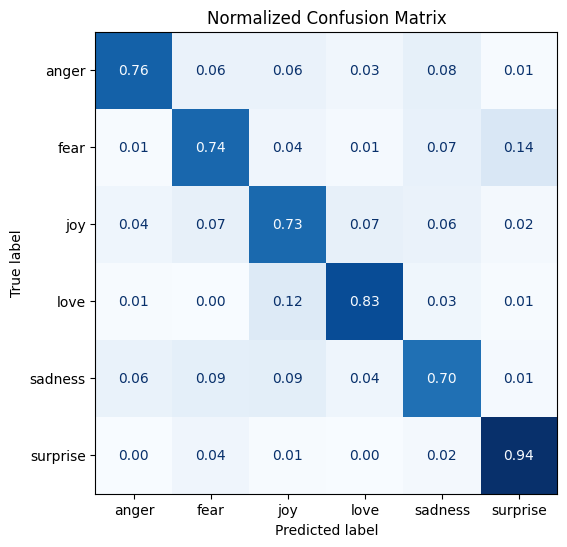

In [16]:


def plot_confusion_matrix(y_predicted, y_true, labels):
    """
    Plot a normalized confusion matrix to visualize classification performance.

    Args:
        y_predicted (array-like): Array of predicted labels from the model.
        y_true (array-like): Array of true labels from the test set.
        labels (array-like): List of class labels to index the matrix. This should match the unique class labels in the dataset.

    Displays:
        - A normalized confusion matrix heatmap where the color intensity represents the proportion of samples for each class.
        - Each cell in the matrix shows the proportion of samples for that class.
    """
    cm = confusion_matrix(y_true, y_predicted, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()

# Example usage
labels = df['label'].unique()  # Extract unique labels from the DataFrame
plot_confusion_matrix(y_pred, y_test, labels)
